In [28]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [29]:
env = BlackjackEnv()

In [30]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        probs = np.zeros(nA) + epsilon / nA
        probs[Q[observation].argmax()] += 1 - epsilon
        return probs
        
    return policy_fn

In [31]:
# quick check
eps = 0.1
Q = {0: np.array([1,2,3]), 1: np.array([2,5,1])}
nA = 3
pi = make_epsilon_greedy_policy(Q,eps,nA)
pi(0)

array([0.03333333, 0.03333333, 0.93333333])

In [32]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for ep in range(num_episodes):
        obs = env.reset()
        steps = []
        for t in range(100):
            action = np.random.choice(env.action_space.n, p=policy(obs))
            new_obs, reward, stop, _ = env.step(action)
            steps.append((obs, action, reward))
            obs = new_obs
            if stop:
                break
        seen = set()
        for i in range(len(steps)):
            obs, act, _ = steps[i]
            if not (obs, act) in seen:
                seen.update([(obs, act)])
                n = returns_count[(obs, act)]
                G = sum([r * (discount_factor ** t) for t, (_, _, r) in enumerate(steps[i:])])
                Q[obs][act] = (n* Q[obs][act] + G) / (n + 1)
                returns_count[(obs, act)] += 1
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, policy

In [33]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

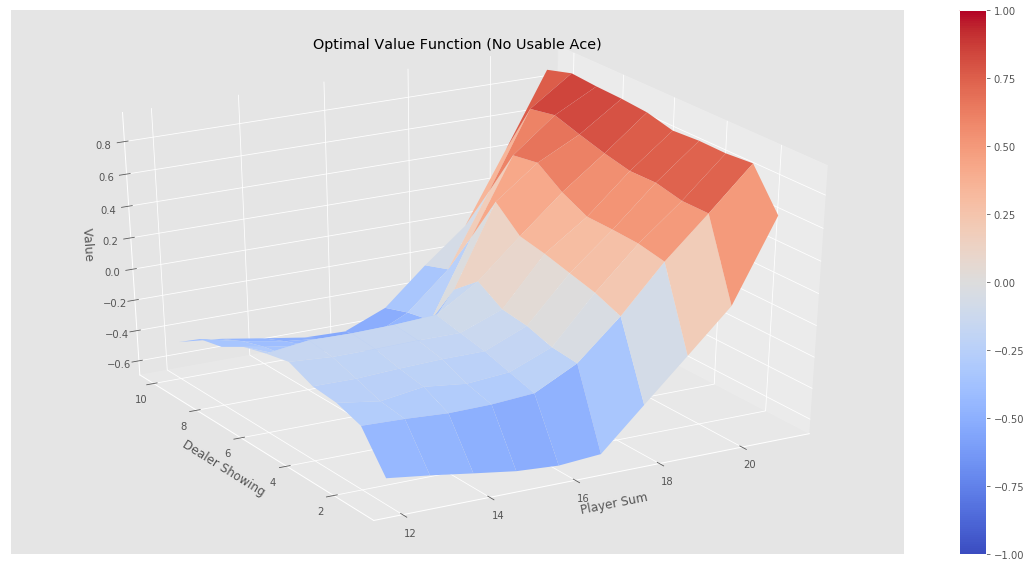

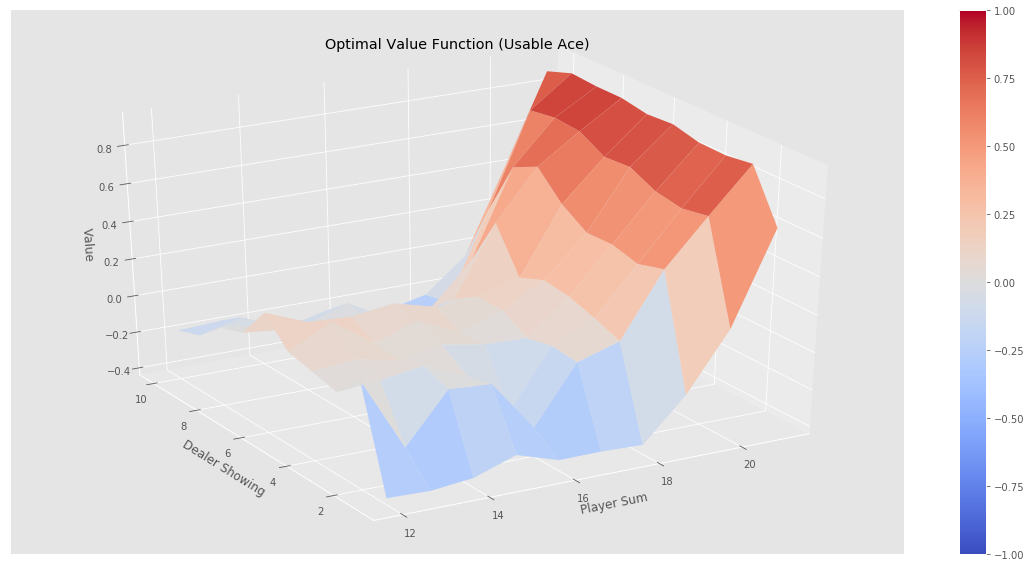

In [34]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")